In [ ]:
# multivariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error

from sklearn.metrics import mean_absolute_error

from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
  #train, test = data[1:-16080], data[-16080:-6] # 6 más del múltiplo de 7
  train, test = data[1:-328], data[-328:-6]

  print(len(train))
  print(len(test))

	# restructure into windows of weekly data
  train = array(split(train, len(train)/7))
  test = array(split(test, len(test)/7))
  return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    #mse = mean_squared_error(actual[:, i], predicted[:, i])

    mae = mean_absolute_error(actual[:, i], predicted[:, i])
    # calculate rmse
    #rmse = sqrt(mse)
    # store
    scores.append(mae)
  # calculate overall RMSE
  s = 0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s += (actual[row, col] - predicted[row, col])**2
  score = sqrt(s / (actual.shape[0] * actual.shape[1]))
  return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 1, 5, 64 # 0, 50, 16
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # reshape output into [samples, timesteps, features]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  # define model
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mae', optimizer='adam') #mse

  callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor="loss"),
    #tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.ModelCheckpoint(filepath='FirstModel.h5'),
  ] 


  # fit network
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=callbacks)
  return model

# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, model


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from influxdb import DataFrameClient

In [ ]:
!pip install influxdb

     |████████████████████████████████| 77 kB 4.6 MB/s 


In [ ]:
dbhost = '34.77.9.141'
dbport = 8086
dbuser = 'root'
dbpasswd = '12345678'
dbname = 'registros_contaminacion'

client = DataFrameClient(dbhost, dbport, dbuser, dbpasswd, dbname)

df = client.query('select * from ESTACION_8')['ESTACION_8']

In [ ]:
df = df[["NO2", "SO2", "PM10", "PM25", "O3"]] # "Categoria"
df

,NO2,SO2,PM10,PM25,O3
2001-01-01 00:00:00+00:00,67.0,26.0,32.0,NaN,7.0
2001-01-01 01:00:00+00:00,71.0,21.0,41.0,NaN,7.0
2001-01-01 02:00:00+00:00,73.0,22.0,50.0,NaN,7.0
2001-01-01 03:00:00+00:00,75.0,19.0,55.0,NaN,7.0
2001-01-01 04:00:00+00:00,67.0,14.0,42.0,NaN,8.0
...,...,...,...,...,...
2022-04-17 03:00:00+00:00,18.0,4.0,8.0,2.0,72.0
2022-04-17 04:00:00+00:00,16.0,5.0,6.0,1.0,71.0
2022-04-17 05:00:00+00:00,19.0,5.0,9.0,4.0,64.0
2022-04-17 06:00:00+00:00,28.0,5.0,12.0,7.0,45.0


In [ ]:
df = df.dropna() # drop NaN

In [ ]:
# split into train and test
train, test = split_dataset(df.values)

101535
322


In [ ]:
train

array([[[52., 10., 35., 14., 24.],
        [50., 10., 19., 12., 28.],
        [45., 10., 22.,  8., 38.],
        ...,
        [41., 10., 21., 11., 48.],
        [45., 10., 22., 10., 42.],
        [35.,  9.,  9.,  4., 50.]],

       [[35.,  9., 37.,  9., 46.],
        [47., 10.,  5.,  1., 34.],
        [51., 10., 11.,  8., 29.],
        ...,
        [55., 10., 19., 10., 23.],
        [51.,  9.,  4.,  4., 25.],
        [50.,  9.,  5.,  2., 23.]],

       [[50.,  9.,  8.,  4., 19.],
        [39.,  9., 14.,  7., 33.],
        [30.,  9.,  5.,  1., 48.],
        ...,
        [19.,  9.,  4.,  2., 56.],
        [26.,  8.,  4.,  2., 45.],
        [29.,  8.,  5.,  1., 30.]],

       ...,

       [[44.,  4., 12.,  8., 41.],
        [30.,  3.,  8.,  6., 52.],
        [26.,  3.,  9.,  6., 53.],
        ...,
        [22.,  3.,  4.,  2., 53.],
        [23.,  3.,  8.,  7., 50.],
        [17.,  3.,  3.,  2., 56.]],

       [[19.,  3.,  1.,  1., 55.],
        [12.,  3.,  1.,  1., 62.],
        [18.,  3.

In [ ]:

# evaluate model and get scores
n_input = 14
score, scores, model = evaluate_model(train, test, n_input)

Epoch 1/5
1587/1587 [==============================] - 50s 30ms/step - loss: 17.9098
Epoch 2/5
1587/1587 [==============================] - 47s 30ms/step - loss: 17.5267
Epoch 3/5
1587/1587 [==============================] - 48s 30ms/step - loss: 17.4649
Epoch 4/5
1587/1587 [==============================] - 47s 30ms/step - loss: 17.4151
Epoch 5/5
1587/1587 [==============================] - 47s 30ms/step - loss: 17.4041


lstm: [20.789] 8.4, 13.6, 18.8, 19.3, 19.2, 17.0, 16.2


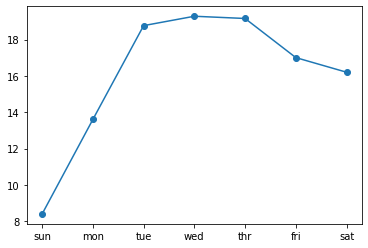

In [ ]:

# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['1h', '2h', '3h', '4h', '5h', '6h', '7h']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()